## Install the PGR-TK package

If neccessary, install the package into your python environment 
```
pip install --force /code/pgrtk-0.3.2-cp38-cp38-linux_x86_64.whl
```

In [1]:
import pgrtk
print(pgrtk.__version__)

pgrtk 0.3.2 (main:00d8eb3, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])


In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.chdir("/results/")

## Lazy load the the AGCfile for fetching sequences

In [4]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc") # lazy load an agc file of the reference without any SHIMMER index 

## Load the index into memory
The loads the index into the memory. It takes about one minute.

In [5]:
%%time
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/data/pgr-tk-HGRP-y1-evaluation-set-v0")

CPU times: user 20.1 s, sys: 2min 16s, total: 2min 36s
Wall time: 2min 2s


Show the specification of the "SHIMMER" used for creating the index

In [6]:
(w, k, r, s, _) = sdb.get_shmmr_spec()
print(f"w={w} k={k} r={r} s={s}")

w=80 k=56 r=4 s=64


## Fetch Reference Sequence and Use it to query the database

This code snippet fetch the regions contains AMY1A (hg19, chr1:104198140-104207173), we also fetch about 15kb franking sequences.

In [7]:
ref_file_name, ROI_chr, ROI_b, ROI_e = 'hg19_tagged.fa', 'chr1_hg19', 104198140, 104207173
padding = 150000
ROI_len = ROI_b - ROI_e
ROI_seq = sdb.get_sub_seq(ref_file_name, ROI_chr, ROI_b-padding, ROI_e+padding)

Let's do a self dot plot with the `get_shmmr_dots()` function of the `ROI_seq`. AMY1A has very interesting repeat pattern

Text(0, 0.5, 'AMY1A')

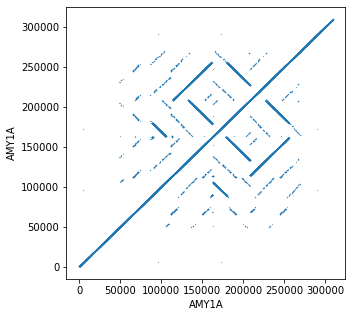

In [8]:
x, y = pgrtk.get_shmmr_dots(ROI_seq, ROI_seq, 32, 32, 2, 2)
plt.figure(figsize=(5,5))
plt.plot(x, y, ".", markersize=0.5)
plt.xlabel("AMY1A")
plt.ylabel("AMY1A")

## Using ROI to query the PGR index to find homologous region 

The `merge_range_tol` control how to merge to result query region. Due to repeats or structure variants, the returned regions maybe fragemented. One can merge the aligend region with in the distance of `merge_range_tol`. Set it zero will return the raw alignment results.

In [9]:
# here we should what the pgrtk.query_sdb() does
help(pgrtk.query_sdb)

Help on function query_sdb in module pgrtk:

query_sdb(seq_index_db, query_seq, gap_penality_factor=0.25, merge_range_tol=12, max_count=128, max_query_count=128, max_target_count=128, max_aln_span=8)
    Query a sequence index database for a query sequence. 
    
    Parameters
    ----------
    seq_index_db : SeqIndexDB object
        a sequence index database object
    
    query_seq : list of bytes
        a list of bytes representing the DNA sequence
    
    gap_penality_factor : float
        the gap penalty factor used in sparse dyanmic programming for finding the hits
    
    merge_range_tol : int
        a parameter used to merge the alignment ranges
    
    max_count : int
        only use the shimmer pairs that less than the ``max_count`` for sparse dynamic programming
    
    max_query_count : int
        only use the shimmer pairs that less than the ``max_count`` in the query sequence for sparse dynamic programming
    
    max_query_count : int
        only use the s

In [10]:
query_results = pgrtk.query_sdb(sdb, ROI_seq, merge_range_tol=100000)

The following code snippet shows how to use the query results to fetch the sequence of all AMY1A in the pangenomcis database. We also show a number of dot-plot from the AMY1A from the pangenomics assembly contigs to the AMY1A in hg19. 

The AMY1A is within the two red lines. And the big repeat structural different changes the number of copy of AMY1A.

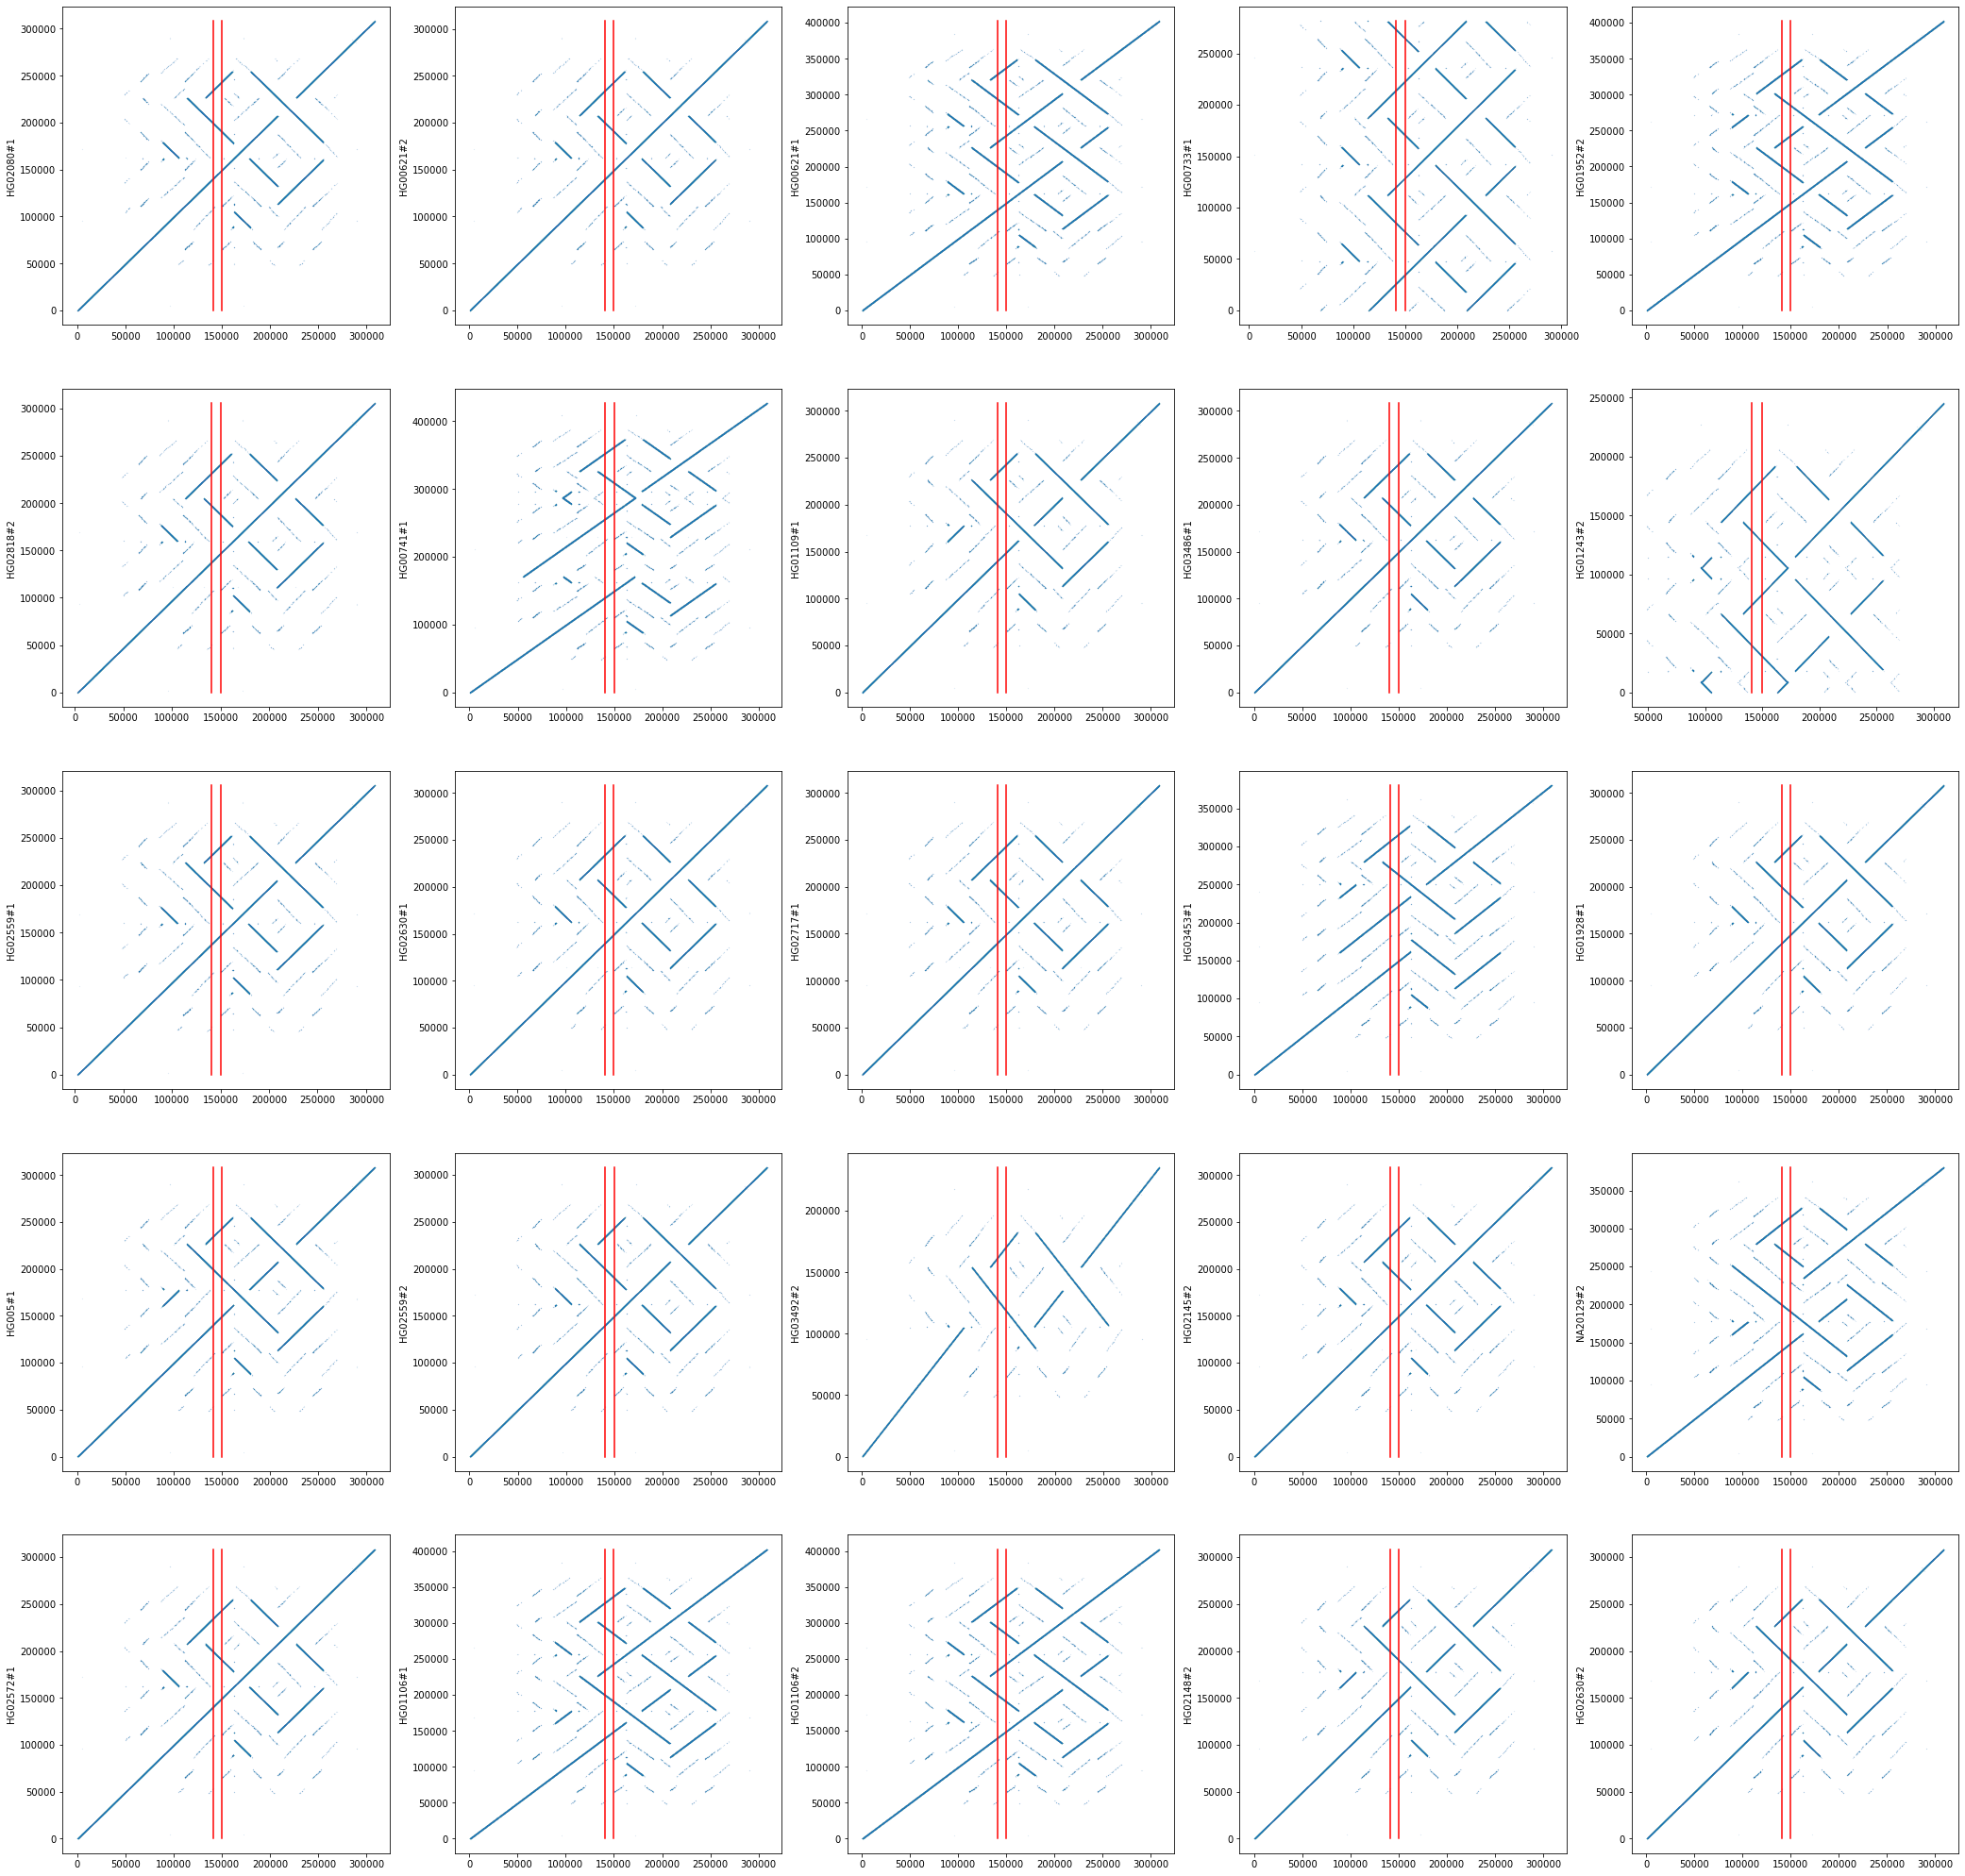

In [11]:
seq_list = []
seq_info = sdb.seq_info.copy() # Cache seq_info to reduce Rust HashMap to Python dictionary conversion in a loop
i = 1
plt.figure(figsize=(36, 36))
for k in list(query_results.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = query_results[k].copy()

    # rgns = pgrtk.merge_regions(rgns,tol=1000) # if additional region merge needed

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        aln.sort()
        #print(aln[0][0][0], aln[-1][0][1])
        if aln[0][0][0] > padding or aln[-1][0][1] < padding + ROI_len:
            continue
        
        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        # print(source, ctg_name, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)

        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        if e-b < len(ROI_seq) * 0.75: # ignore partial match
            continue
        else:
            x, y = pgrtk.get_shmmr_dots(ROI_seq, seq, 32, 32, 1, 1)
            if i <= 25:
                plt.subplot(5,5,i)
                plt.plot(x, y, ".", markersize=0.1)
                ylabel = "#".join(ctg_name.split("#")[:2])
                if len(ylabel) > 20:
                    ylabel = ylabel[:20]
                plt.ylabel(ylabel)
                plt.plot([padding, padding],[0, max(y)], "r")
                plt.plot([padding+ROI_len, padding+ROI_len],[0, max(y)], "r")
            i += 1

The results are stored in `seq_list`. We can write it out to a fasta file for other downstream analysis in the future. We can also rebuild a PGR index on fily with different SHIMMER specification to create a more detailed Minimizer Anchored Pan-genomics Graph (MAPG) for this region of interest.

In [12]:
f = open("AMY.fa", "w")
for name, seq in seq_list:
    print(f">{name}", file=f)
    print(pgrtk.u8_to_string(seq), file=f)
f.close()

Build a new PGR database and index from the fetched sequences

In [13]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=2, min_span=28)

Output the Minimizer Anchored Pan-Genomics Graph in a GFA format

In [14]:
new_sdb.generate_mapg_gfa(0, "AMY.gfa")
new_sdb.write_midx_to_text_file("AMY.midx")  # `AMY.midx` contains meta-data to the segments inside `AMY.gfa`

Showing the layout of the graph with Bandage

In [15]:
from IPython.display import Image

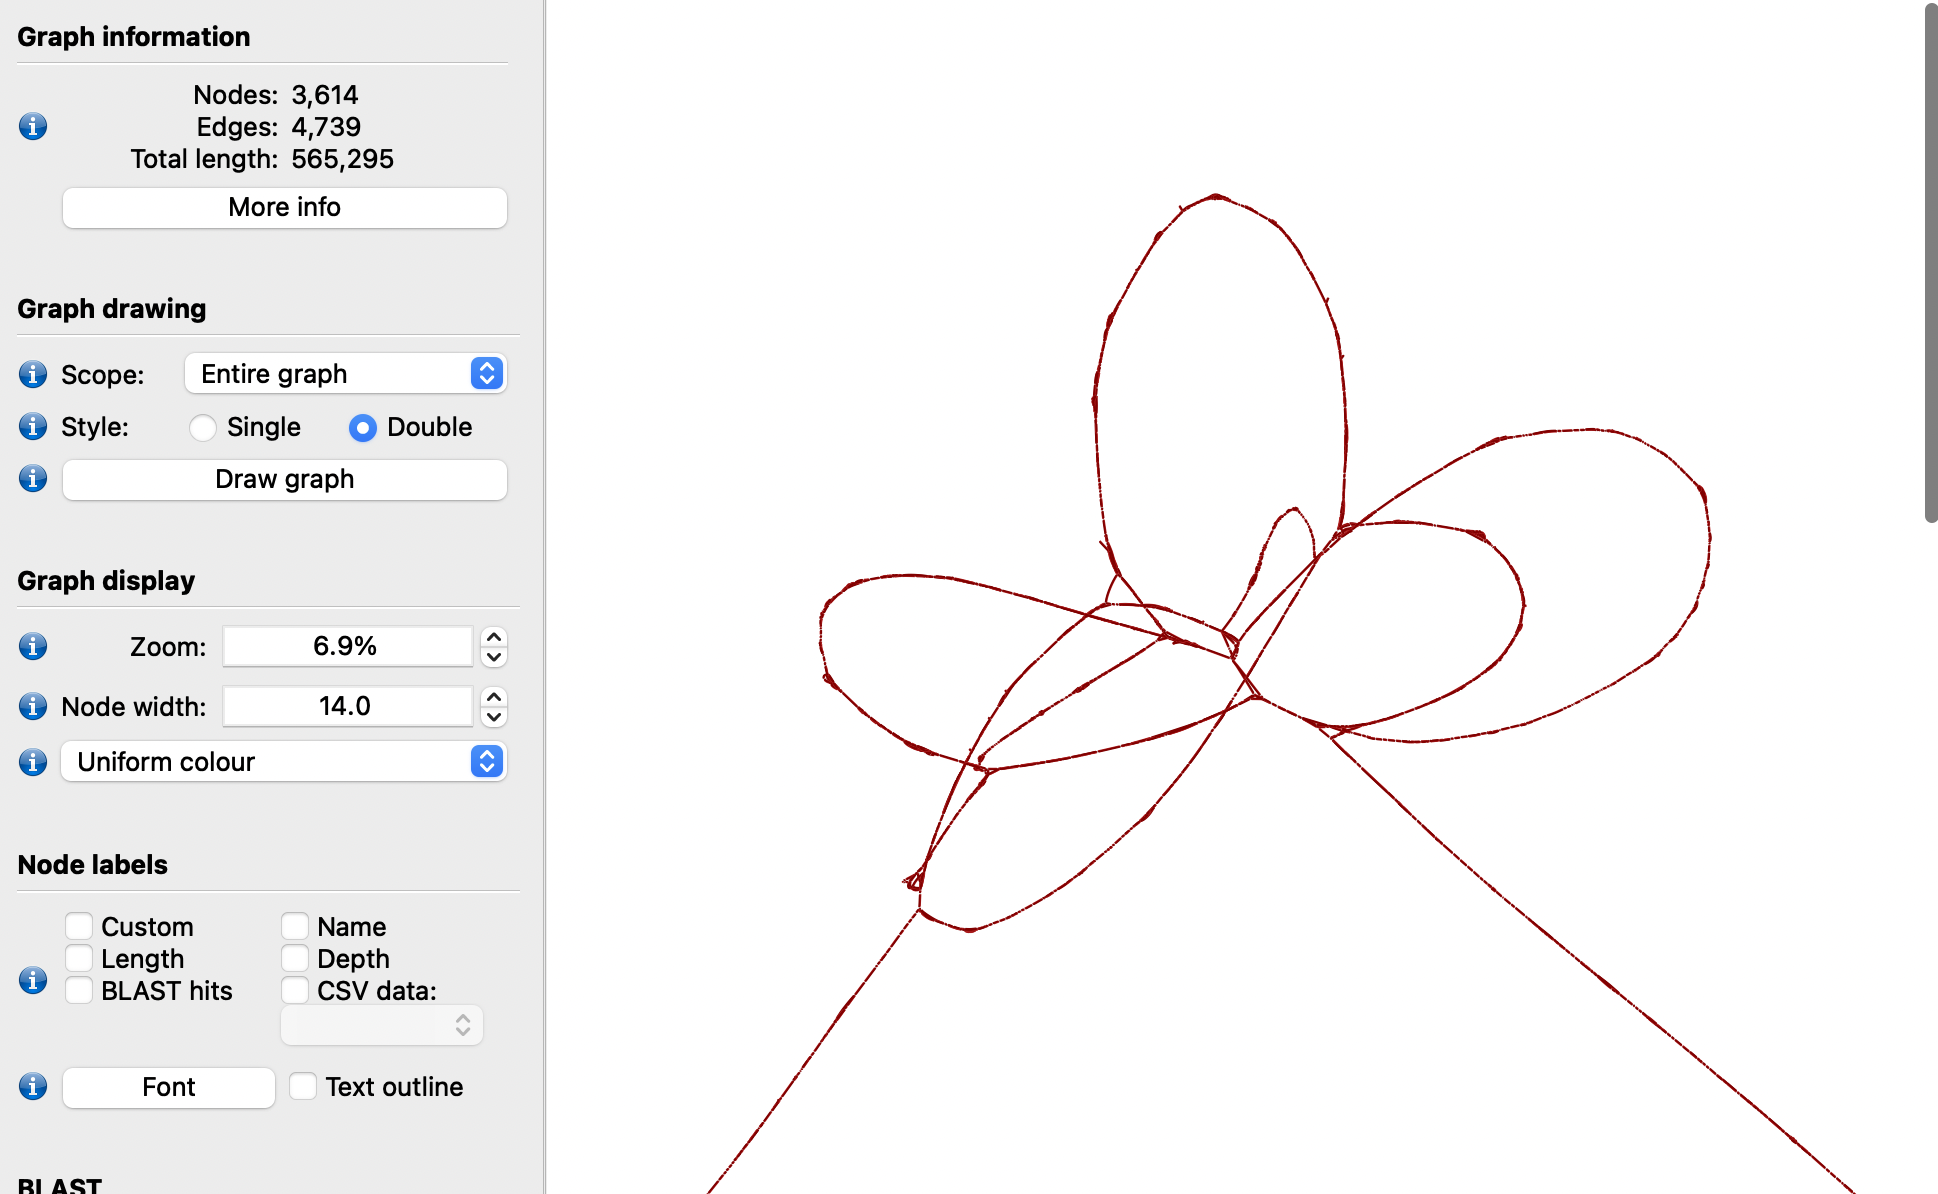

In [16]:
Image("/data/AMY1A_gfa_view.png")